# Cutting Cloud Costs with Infrastructure Automation (Part III - Preparing and Training Code on AWS - MNIST)
## Review
At this point, we have a working EC2 instance loaded with the AWS Deep Learning AMI, with the jupyter notebook tested and ready to go.

<img src="https://media.giphy.com/media/v1HYJrnAMt6gM/giphy.gif" style="width: 500px;"/>

The last step I want to take to automate this analysis as much as I can is to just get a notebook ready so I can just import it and run it. I'll start with the MNIST data set because I basically already have that code written and tested on my own laptop. All I need to do is to
- Prepare a jupyter notebook
- Host it on git
- Fire up my EC2
- Clone the project and code onto the EC2
- Train on the EC2
- View / save results
- Terminate the EC2 and _**stop the billing**_

Theoretically, this should take no longer than like 5 minutes to set up, and then however long it takes for the model to train (I'm hoping for like less than 30 minutes for 10 epochs, but I honestly have no clue what to expect). I'll use this as the notebook to clone and run on the EC2.

## MNIST Model
Please refer to post \#3 for the fully documented and commentated code. To keep this post light, I'm just going to use the code from post \#3. MNIST should be good example for automation too because it comes with a built in function that loads the data so we don't even have to worry too much about the ETL portion.

### Cost
I just wanted to preface this notebook first by noting how much this exercise will cost me. If things go well, my balance after will only be $0.20 more than it is right now. Current balance:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/43_aws_billing_before.png" style="width: 500px;"/>

That exchange rate is killing me... but what can I really do?

<img src="https://i.giphy.com/media/e3C4pNKkr9rji/giphy.webp" style="width: 400px;"/>

In [2]:
# Install tflearn
import os
os.system("sudo pip install tflearn")

0

In [3]:
# TFlearn libraries
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tflearn.datasets.mnist as mnist

# General purpose libraries
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
# Extract data from mnist.load_data()
x, y, x_test, y_test = mnist.load_data(one_hot = True)

Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/train-images-idx3-ubyte.gz
Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [5]:
# Reshape x
x_reshaped = x.reshape([-1, 28, 28, 1])
print 'x_reshaped has the shape {}'.format(x_reshaped.shape)

x_reshaped has the shape (55000, 28, 28, 1)


In [6]:
# Reshape x_test
x_test_reshaped = x_test.reshape([-1, 28, 28, 1])
print 'x_test_reshaped has the shape {}'.format(x_test_reshaped.shape)

x_test_reshaped has the shape (10000, 28, 28, 1)


In [7]:
# sentdex's code to build the neural net using tflearn
#   Input layer --> conv layer w/ max pooling --> conv layer w/ max pooling --> fully connected layer --> output layer
convnet = input_data(shape = [None, 28, 28, 1], name = 'input')

convnet = conv_2d(convnet, 32, 2, activation = 'relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation = 'relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation = 'relu')
# convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 10, activation = 'softmax')
convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')

In [11]:
model = tflearn.DNN(convnet)
model.fit(
    {'input': x_reshaped}, 
    {'targets': y}, 
    n_epoch = 5, 
    validation_set = ({'input': x_test_reshaped}, {'targets': y_test}), 
    snapshot_step = 500, 
    show_metric = True
)

Training Step: 4299  | time: 10.886s
| SGD | epoch: 005 | loss: 0.00000 - acc: 0.0000 -- iter: 54976/55000
Training Step: 4300  | time: 12.184s
| SGD | epoch: 005 | loss: 0.00000 - acc: 0.0000 | val_loss: 0.11502 - val_acc: 0.9648 -- iter: 55000/55000
--


## Results

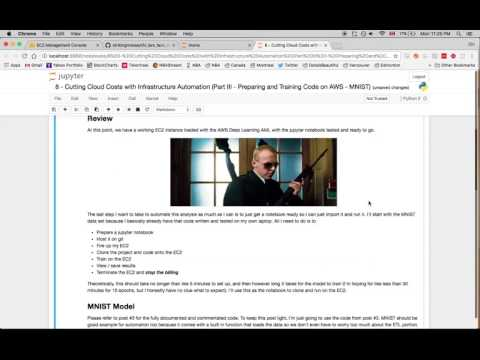

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('iuBAnwWI8uU')

Again, it was a bit easier to actually just make a quick video showing the model running on AWS to really get a sense of how fast the model trained. 12-13 seconds _**per epoch**_!!

After _**1 minute / 5 epochs**_, we got to ~97%! To reiterate the findings of the video, performing the model training on AWS literally took _**23 times faster**_ than training on my laptop. It took _**less than 5%**_ of the time it took on my laptop. Amazing gains for a very low price. You could argue that it took a while just to get this whole environment up and running, but the lead time to get it up again for the next analysis is next to nothing. We have our Terraform script, the AWS Deep Learning AMI, and a local jupyter environment to prepare our code in before porting it to AWS to run on a GPU-optimized instance.

_**23 times faster**_... I had an idea it would be faster, but I'm blown away by how much faster.

I think I'm ready to try it on our faces!